# US Arrests Exploration with PCA and Clustering

https://github.com/willgosnold/US_arrests

## Introduction

In this notebook, we are going to explore a dataset from 1973 that contains the number of arrests per 100,000 residents for each of a series of violent crimes in each US state. It also contains data on the percentage of the population living in urban areas in those states.

We will be performing a principal component analysis (PCA) to reduce the dimensionality of the data, and then perform agglomerative and k-means clustering to see how the states might be grouped together. We can then check the clusters to see if there are any noticeable commonalities between the states in each cluster.

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans

### Loading the data

To start, we will load the data into a pandas dataframe and take a look at the first few rows. We can see below that the dataset will require some cleaning, as it currently lists the State column as "City". We should also notice that the figures for each crime differ greatly so will need to think about how to scale the data at some point.

In [267]:
# Load the data
arrests_df = pd.read_csv("data/UsArrests.csv")

In [268]:
# Show the first 5 rows
arrests_df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.20,236,58,21.20
1,Alaska,10.00,263,48,44.50
2,Arizona,8.10,294,80,31.00
3,Arkansas,8.80,190,50,19.50
4,California,9.00,276,91,40.60


### Cleaning the data

Let's now rename the "City" column to "State" and then let's also map the state names to their abbreviations. This will make it easier to plot the data later on.

In [269]:
# Rename city column to state
arrests_df.rename(columns={"City": "State"}, inplace=True)

In [270]:
# Map state names to state abbreviations
state_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

arrests_df["State_abv"] = arrests_df["State"].map(state_abbrev)

### Abbreviation confirmation

We can check that the mapping worked correctly and see that our "State_abv" column now contains only the two-letter state abbreviations.

In [271]:
# Show new State_abv column
arrests_df.State_abv.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
       'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
       'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

### Additional Information

We can also look at some additional information about our data, such as confirming the the number of states and features in the dataset, and also the number of missing values in each column. Let's then also look at the summary statistics for each of the features.

In [272]:
# Show the number of states and features
print(f"Number of States:\t{arrests_df.shape[0]}\nNumber of Features:\t{arrests_df.shape[1] - 1}")

Number of States:	50
Number of Features:	5


In [273]:
# Show the number of missing values for each column
missing = pd.DataFrame(arrests_df.isnull().sum(), columns=["missing"])
missing

,missing
State,0
Murder,0
Assault,0
UrbanPop,0
Rape,0
State_abv,0


In [274]:
# Set the decimal precision to 3
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# Show relevant statistics for each column
stats = arrests_df.describe()
chosen_stats = stats.loc[["mean", "std", "min", "max"]].T
chosen_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


### Data Types

It is also a good idea to double check that the data types are correct. We can see below that "State" and "State_abv" are object columns which makes sense as they contain strings of the states and the abbreviations. We can also see that the other columns are all either integers or floats, which is what we would expect.

In [275]:
# Show DataFrame info for datatypes etc
arrests_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   State      50 non-null     object 
 1   Murder     50 non-null     float64
 2   Assault    50 non-null     int64  
 3   UrbanPop   50 non-null     int64  
 4   Rape       50 non-null     float64
 5   State_abv  50 non-null     object 
dtypes: float64(2), int64(2), object(2)
memory usage: 2.5+ KB


### Data Summary

From our summary statistics and missing values exploration, we can create an overall summary dataframe containing the most relevant information about our data. This can also be saved to a CSV file for future reference.

Shown below, we can see that the "Murder" feature ranges from 0.8 to 17.4 cases/100,000 residents, with a mean of 7.79. The "Assault" feature ranges from 45 to 337 cases/100,000 residents, with a mean of 170.76. The "Rape" feature ranges from 7.3 to 46.0 cases/100,000 residents, with a mean of 21.23. Finally, the "UrbanPop" feature ranges from 32% to 91% of the total population for each state living in urban areas with a mean of 65.54%. We can also see the standard deviation for each of these features, as well as confirmation that there are no missing data values.

In [276]:
# Create overall data summary
frames = [missing, chosen_stats]
summary = pd.concat(frames, axis=1)

# Save as csv
summary.to_csv("data/summary.csv")

summary

,missing,mean,std,min,max
State,0,NaN,NaN,NaN,NaN
Murder,0,7.79,4.36,0.80,17.40
Assault,0,170.76,83.34,45.00,337.00
UrbanPop,0,65.54,14.47,32.00,91.00
Rape,0,21.23,9.37,7.30,46.00
State_abv,0,NaN,NaN,NaN,NaN


### Data Visualisation

Let's now have a look at these feature distributions in a more accessible way by plotting them on a boxplot diagram. We can see confirmation that the features have very different scales to one another and as such are hard to compare. 

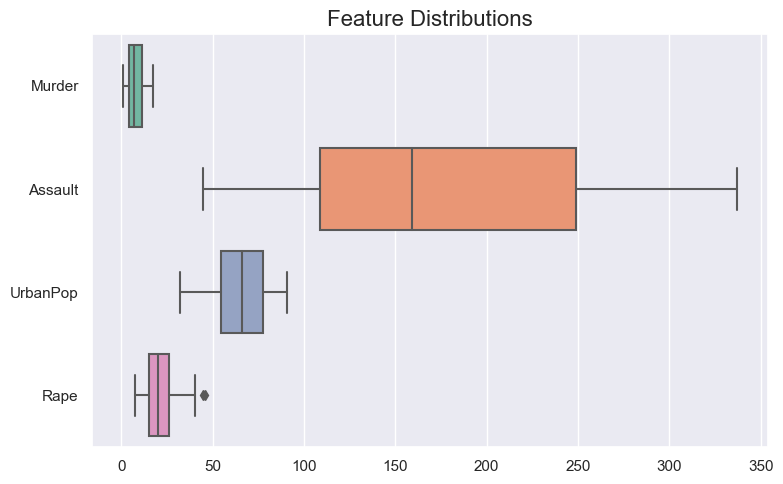

In [277]:
# Set darkgrid theme
sns.set_theme(style="darkgrid")

# Make boxplots of the features
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=arrests_df, orient="h", palette="Set2")

# Add axis label, title, and show
plt.title("Feature Distributions", size=16)
plt.tight_layout()
plt.show()

### Correlation Matrix

We would expect that crime rates across the features would be correlated with one another, but we can confirm this and look to see if there is also a confirmation between these features and the UrbanPop feature by plotting them on a heatmap.

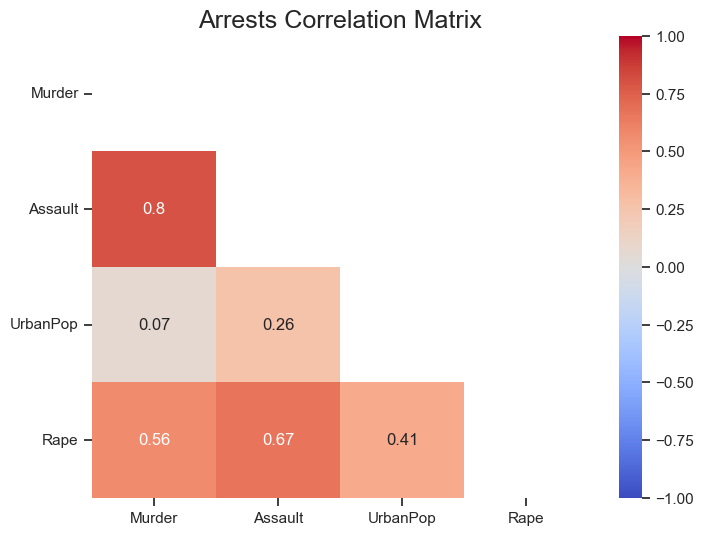

In [278]:
# Set ticks theme
sns.set_theme(style="ticks")

# Create correlation matrix of features
plt.figure(figsize=(8, 6))
corr_df = arrests_df.drop(["State"], axis=1).corr(numeric_only=True)
# Mask the upper triangle
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm", annot=True, vmin=-1, vmax=1)

# Rotate the xticks
plt.yticks(rotation=0)
# Add a title and show
plt.title("Arrests Correlation Matrix", size=18)
plt.show()

### Correlation Analysis

We can see that "Assault" and "Murder" are the most highly correlated with a coefficient of 0.8 (0 would mean no correlation, 1 would be perfectly correlated). The lowest correlations are found between "UrbanPop" and each of the crimes, with a completely negligible coefficient of 0.07 between "Murder" and "UrbanPop".

One of the benefits of PCA, is that when we reduce the dimensionality of the data, we can also create features that are far less correlated than the original features.

### Data Scaling

Let's now move on to scaling our data. We have seen that the features are very different from one another and as such, to be able to compare them effectively, we want to scale the data before continuing with our PCA.

In [279]:
# Define the features as X
X = arrests_df.drop(["State", "State_abv"], axis=1).values

In [280]:
# Scale the data
X = StandardScaler().fit_transform(X)

### Principal Component Analysis (PCA)

Now that we have scaled the data, we can actually create our PCA model and transform our data to find our new features. To start with, we will not define the number of principal components that we want, and instead have as many as we have original features. In this case, that will be 4 principal components. 

We can then explore these components to see how necessary each is and if we could potentially reduce the dimensionality. We would need to make sure that we still have enough information in order to make useful insights about the data.

In [281]:
# Initialise PCA model
pca = PCA()

In [282]:
# Create PCA dataframe with principal components
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4"])
df_pca.head()

,PC1,PC2,PC3,PC4
0,0.99,1.13,-0.44,0.16
1,1.95,1.07,2.04,-0.44
2,1.76,-0.75,0.05,-0.83
3,-0.14,1.12,0.11,-0.18
4,2.52,-1.54,0.60,-0.34


### Initial Analysis of PCA Components

Now that we have our transformed dataset of the PCA components, we can look at various statistics about them, such as the standard deviation, the proportion of variance explained by each component, and the cumulative proportion of variance explained by each component.

We can see below that the first component explains around 62% of the variance in the data, the second component explains around 25% of the variance, the third component explains around 9% of the variance, and the fourth component explains the final 4% of the variance. We can graph these findings as well to visualise this more clearly.

In [283]:
# Show standard deviation of each principal component
std = df_pca.describe().transpose()["std"]
for i, std in enumerate(std):
    print(f"Standard Deviation of PC{i+1}:\t{std:.2f}")


Standard Deviation of PC1:	1.59
Standard Deviation of PC2:	1.00
Standard Deviation of PC3:	0.60
Standard Deviation of PC4:	0.42


In [284]:
# Show proportion of variance explained by each principal component
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"Proportion of Variance Explained by PC{i+1}:\t{var:.4f}")

Proportion of Variance Explained by PC1:	0.6201
Proportion of Variance Explained by PC2:	0.2474
Proportion of Variance Explained by PC3:	0.0891
Proportion of Variance Explained by PC4:	0.0434


In [285]:
# Show cumulative proportion of variance explained by each principal component
print(f"Cumulative Proportion of Variance Explained:\t{np.cumsum(pca.explained_variance_ratio_)}")

Cumulative Proportion of Variance Explained:	[0.62006039 0.86750168 0.95664248 1.        ]


### Explained Variance Visualisation

Let's now have a look at the graphs that can show us this explained variance more clearly. We can set a threshold at 90% and see that we would need to keep the first 3 components in order to explain at least 90% of the variance in the data. The first is a Cumulative Explained Variance plot, and the second is a Scree Plot. Both show similar information, in a slightly different way. 

The scree plot is a commonly used method to determine the number of principal components to keep. Usually, we would be looking for a distinct change in the slope of the line, which would indicate that the next component is not adding much more information to the data. We can see that this is the case for the third component, and so we would be able to reduce the dimensionality of the data to 3 components.

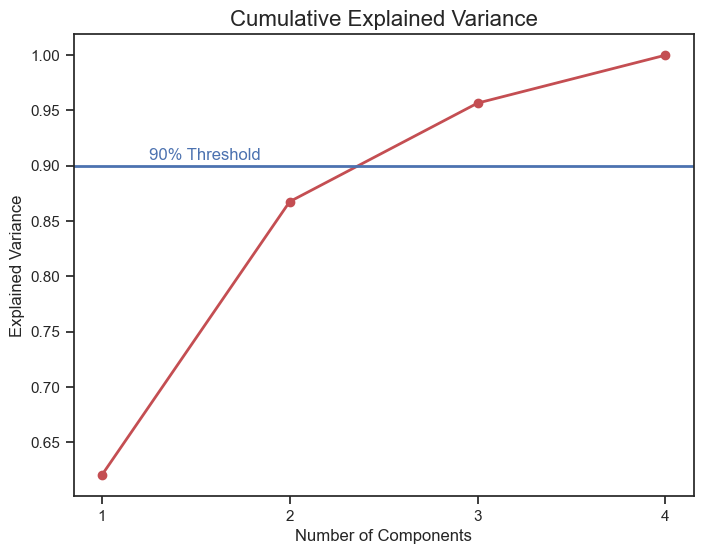

In [286]:
# Cumulative variance plot
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_),"ro-", linewidth=2)
plt.axhline(y=0.9, color="b", linestyle="-", linewidth=2)

# Add title and labels
plt.title("Cumulative Explained Variance", size=16)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
# Add threshold line
plt.text(0.25, 0.905, "90% Threshold", color="b", fontsize=12)
# Correct xticks
plt.xticks(range(4), [i+1 for i in range(4)])
plt.show()

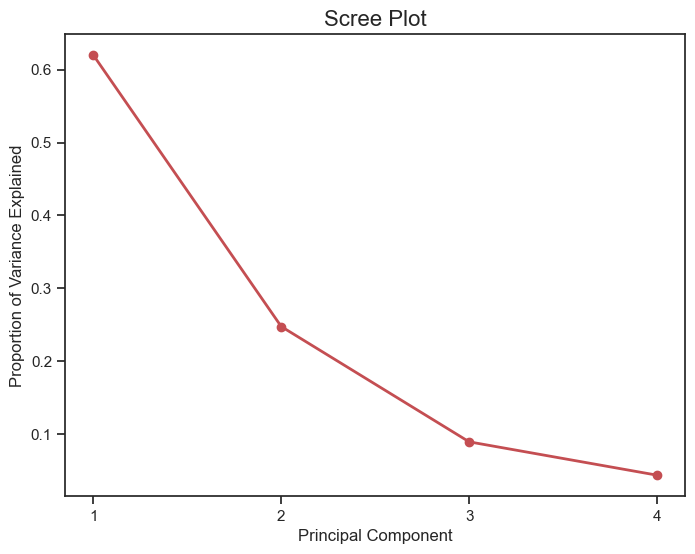

In [287]:
# Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_, "ro-", linewidth=2)

# Add title and labels
plt.title("Scree Plot", size=16)
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
# Correct xticks
plt.xticks(range(4), [i+1 for i in range(4)])
plt.show()

### Biplot

Now, we can also create a biplot to visualise the data in 2 dimensions. This will allow us to see how the states are distributed across the first two principal components. We can also see the feature vectors for each of the original features, and how they relate to the principal components. 

These vectors show us that the first principal component is primarily made up of the crime features. The second principal component is primarily made up of the "UrbanPop" feature. This is something that we can determine based on the direction of the vectors, as well as the length of the vectors. The longer the vector, the more important that feature is to that principal component.

In [288]:
def biplot(pca_scores, coefficients, point_labels=None, data_points=None):
    """Creates a biplot of the principal components and feature coefficients.

    Parameters
    ----------
    pca_scores : numpy.ndarray
        The principal component scores.
    coefficients : numpy.ndarray
        The feature coefficients.
    point_labels : list, optional
        The labels for the principal components, by default None
    data_points : list, optional
        The labels for the data points, by default None
    
    Returns
    -------
    None, but shows a biplot of the principal components and feature coefficients.
    """

    # Select first two principal components
    x_coordinates = pca_scores[:, 0]
    y_coordinates = pca_scores[:, 1]
    n = coefficients.shape[0]  # Number of original features
    # Get scaling factors
    x_scaling = 1.0 / (x_coordinates.max() - x_coordinates.min())
    y_scaling = 1.0 / (y_coordinates.max() - y_coordinates.min())

    # Plot biplot
    fig, ax = plt.subplots(figsize=(12, 12))

    ax.scatter(x_coordinates * x_scaling, y_coordinates * y_scaling, s=5)

    # Check if data_points are provided and if so, annotate them
    if data_points is not None:
        for i, point_label in enumerate(data_points):
            ax.annotate(
                point_label, (x_coordinates[i] * x_scaling, y_coordinates[i] * y_scaling), rotation=35
        )

    # Plot feature vectors
    for i in range(n):
        ax.arrow(0, 0, coefficients[i, 0], coefficients[i, 1], color="r", alpha=0.5)

        # If not provided, label the feature vectors with the feature number
        if point_labels is None:
            ax.text(
                coefficients[i, 0] * 1.1,
                coefficients[i, 1] * 1.05,
                "Var" + str(i + 1),
                color="green",
                ha="center",
                va="center",
            )
        # If provided, label the feature vectors with the feature name
        else:
            ax.text(
                coefficients[i, 0] * 1.1,
                coefficients[i, 1] * 1.05,
                point_labels[i],
                color="g",
                ha="center",
                va="center",
                size=14,
            )
    
    # Set axis limits
    ax.set_xlim(None, 0.7)

    # Add axis labels, title and show
    plt.title("Biplot of First 2 Principal Components", size=18)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()


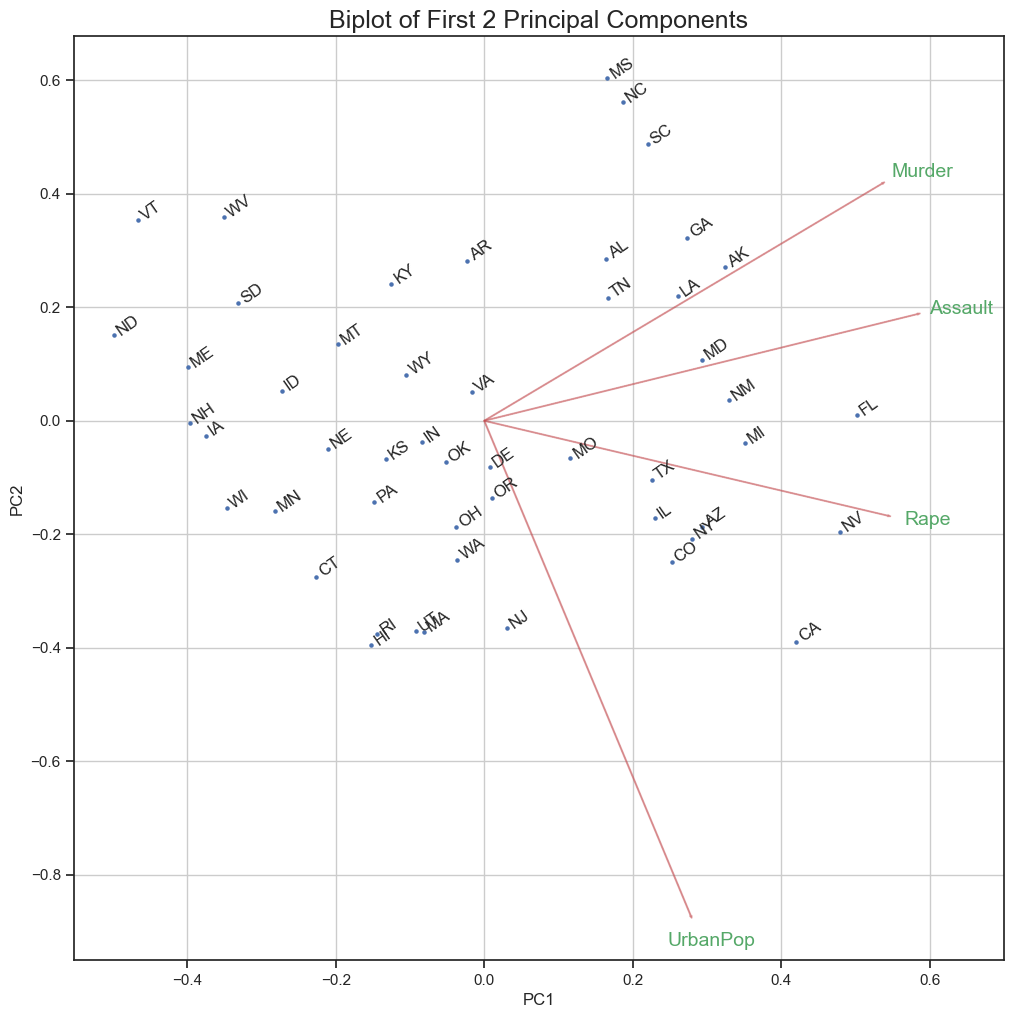

In [289]:
# Get the feature coefficients
coefficients = np.transpose(pca.components_[0:2, :])

# Plot biplot
biplot(X_pca[:, 0:2], coefficients, point_labels=arrests_df.columns[1:], data_points=arrests_df["State_abv"])

### Feature Importance

The scikit-learn implementation of the PCA model also allows us to access the feature importance of each of the original features. We can see below that the "Assault" feature is the most important feature for the first principal component with a coefficient of 0.58, and the "UrbanPop" feature is the most important feature for the second principal component with a coefficient of 0.87.

This is the same data as we saw in the biplot above, outlined in a table view instead of the graph.

In [290]:
# Feature Importance
pc_1 = abs(pca.components_[0])
pc_2 = abs(pca.components_[1])

# Create a dataframe
feature_importance = pd.DataFrame(
    {"Feature": arrests_df.columns[1:-1], "PC1 Importance": pc_1, "PC2 Importance": pc_2}
)

feature_importance

,Feature,PC1 Importance,PC2 Importance
0,Murder,0.54,0.42
1,Assault,0.58,0.19
2,UrbanPop,0.28,0.87
3,Rape,0.54,0.17


### PCA Dataframe

Having chosen to use 3 principal components to represent our data, we can now create a new dataframe containing the first 3 principal components. We can then also add the "State_abv" column back into the dataframe so that we can plot the data later on. This will then be our dataset that we will use for the clustering analysis.

In [291]:
# Define df_pca with chosen number of principal components
df_pca = pd.DataFrame(X_pca[:,:3], index=arrests_df["State_abv"], columns=["PC1", "PC2", "PC3"])
df_pca.head()

,PC1,PC2,PC3
State_abv,,,
AL,0.99,1.13,-0.44
AK,1.95,1.07,2.04
AZ,1.76,-0.75,0.05
AR,-0.14,1.12,0.11
CA,2.52,-1.54,0.60


### PCA Correlation Matrix

We can now look at the correlation matrix for our new dataset, and see that the correlation coefficients are much lower than the original features. This is what we would expect, as we have reduced the dimensionality of the data. The scientific notation is used to show the very small numbers, as rounding to 2 decimal places would result in 0.00 for all of the coefficients. We can see that in the table shown below the correlation heatmap.

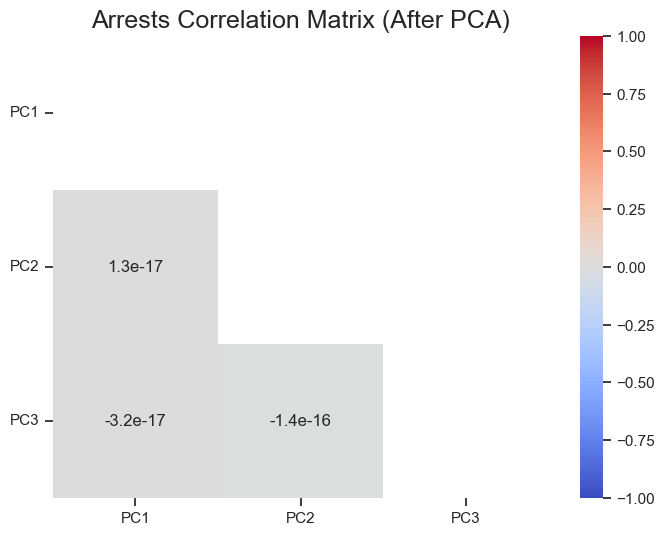

In [292]:
# Set tick theme
sns.set_theme(style="ticks")

# Define size
plt.figure(figsize=(8, 6))
# Create correlation matrix
corr_df = df_pca.corr()
# Create mask for upper triangle
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm", annot=True, vmin=-1, vmax=1)

# Rotate the xticks
plt.yticks(rotation=0)
# Add a title
plt.title("Arrests Correlation Matrix (After PCA)", size=18)
plt.show()

In [293]:
# Confirm correlation matrix
corr_df

,PC1,PC2,PC3
PC1,1.00,0.00,-0.00
PC2,0.00,1.00,-0.00
PC3,-0.00,-0.00,1.00


# Hierarchical Clustering

### Dendrogram

With hierarchical or agglomerative clustering, we have various different options for linkage methods that will each provide different results. We can try a few of them and see which one gives us the best results. Below, we have plotted the dendrograms for "single", "complete", "average", and "ward" linkage. We can see that the most distinct clusters are found with the "ward" linkage method. 

We have plotted the "ward" linkage dendrogram again with greater clarity below. Cutting the dendrogram at a height of 6 would give us 4 distinct clusters. We can use that information to inform our choice of the number of clusters for our K-Means clustering analysis.

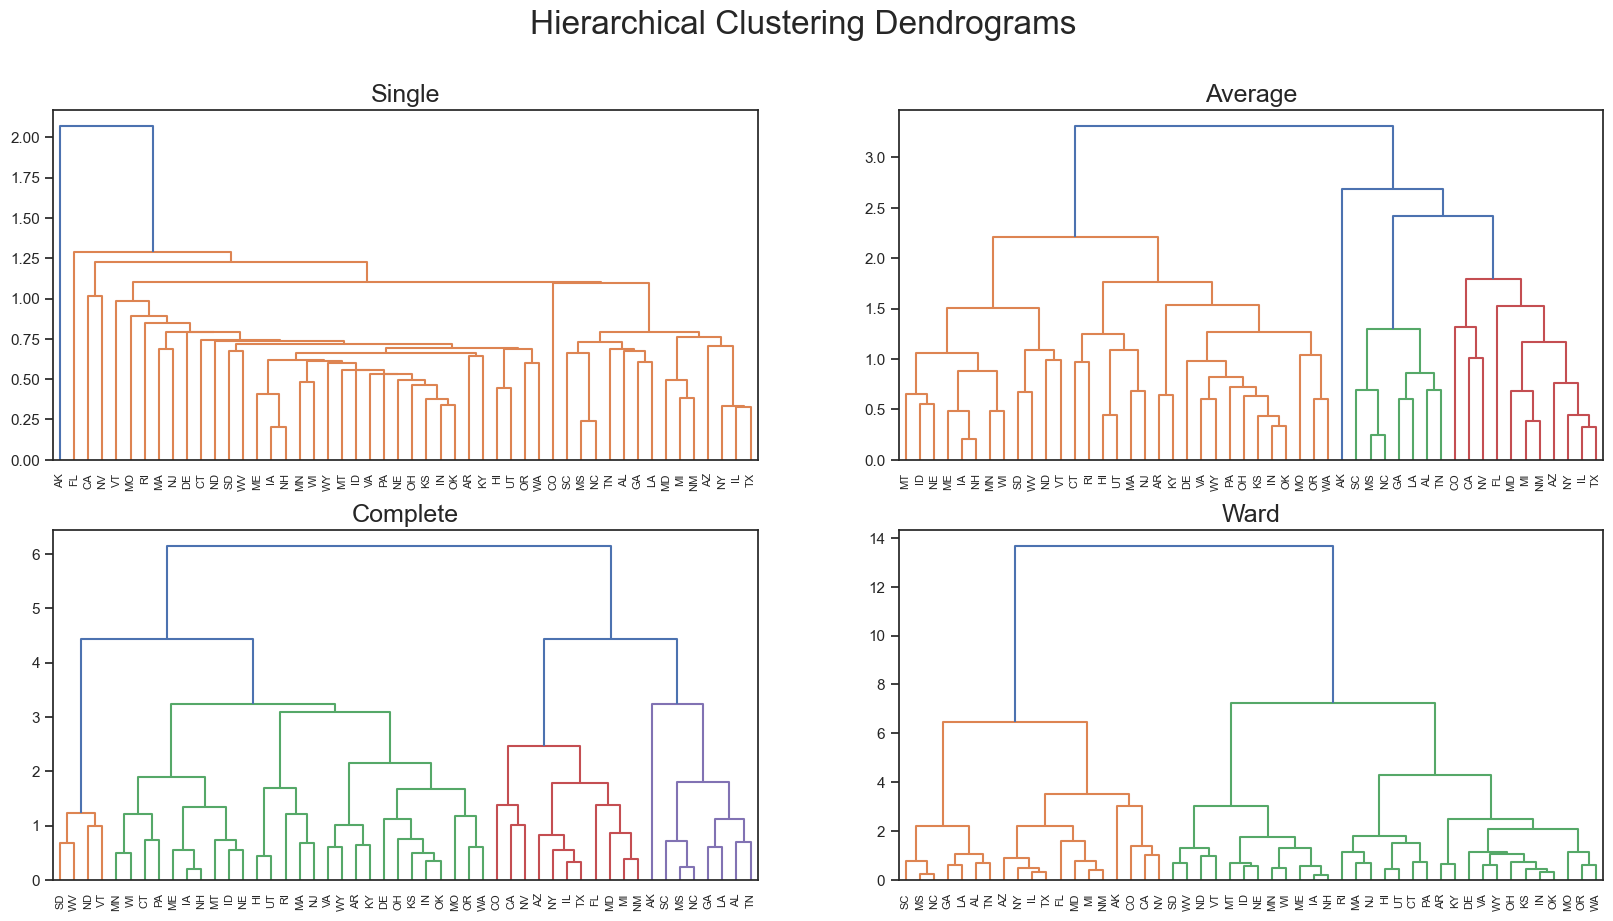

In [303]:
# Initialise an agglomerative clustering model and fit to PCA data
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(df_pca)

# Plot dendrograms for each linkage method
fig, axs = plt.subplots(2, 2, figsize= (20,10))
# Add overall title
fig.suptitle("Hierarchical Clustering Dendrograms", fontsize=24)

# PLot individual dendrograms and titles
axs[0][0].set_title("Single", fontsize=18)
dendrogram(linkage(df_pca, method="single"), labels=df_pca.index, ax=axs[0][0])
axs[0][1].set_title("Average", fontsize=18)
dendrogram(linkage(df_pca, method="average"), labels=df_pca.index, ax=axs[0][1])
axs[1][0].set_title("Complete", fontsize=18)
dendrogram(linkage(df_pca, method="complete"), labels=df_pca.index, ax=axs[1][0])
axs[1][1].set_title("Ward", fontsize=18)
dendrogram(linkage(df_pca, method="ward"), labels=df_pca.index, ax=axs[1][1])

plt.show()

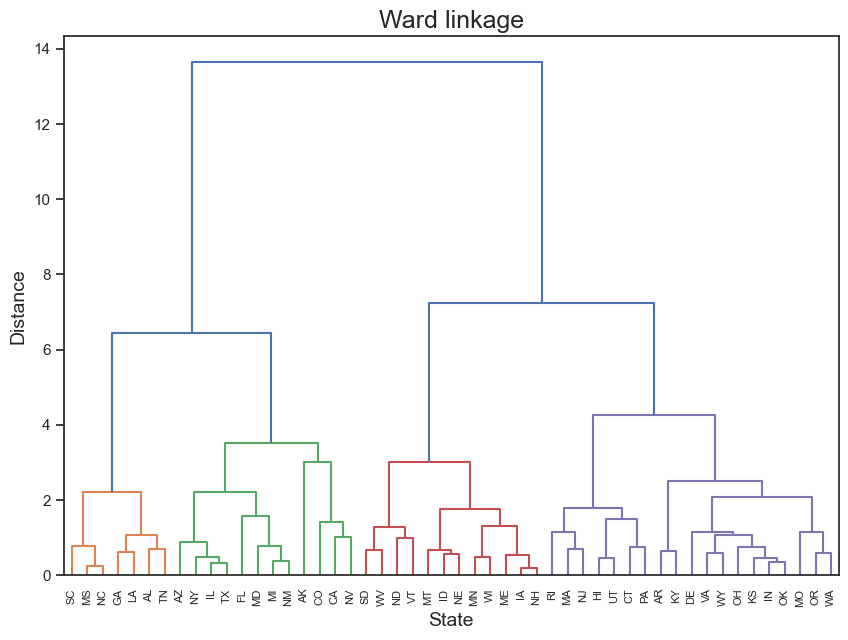

In [304]:
# Plot clearer dendrogram for ward linkage
plt.figure(figsize=(10, 7))

dendrogram(linkage(df_pca, method='ward'), labels=df_pca.index, color_threshold=6)

# Add axis labels
plt.xlabel("State", size=14)
plt.ylabel("Distance", size=14)
# Add title and show
plt.title("Ward linkage", size=18)
plt.show()

# K-Means Clustering

### Cluster plot

We can now use the K-Means clustering algorithm to cluster the data into 4 clusters. We can then plot the data on a scatter plot, with the clusters represented by different colours. 

We start by extracting the first two principal components from the PCA dataframe, and plot our data relative to these as they are the components that explain the most variance in the data.

In [296]:
# Extract the first two principal components for plotting
pc_1 = X_pca[:, 0]
pc_2 = X_pca[:, 1]

In [297]:
# Fit a k-means estimator
k = 4  # From dendrogram clusters
kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=23)

# Get cluster labels and cluster centers
cluster_labels = kmeans.fit_predict(df_pca)
centers = kmeans.cluster_centers_

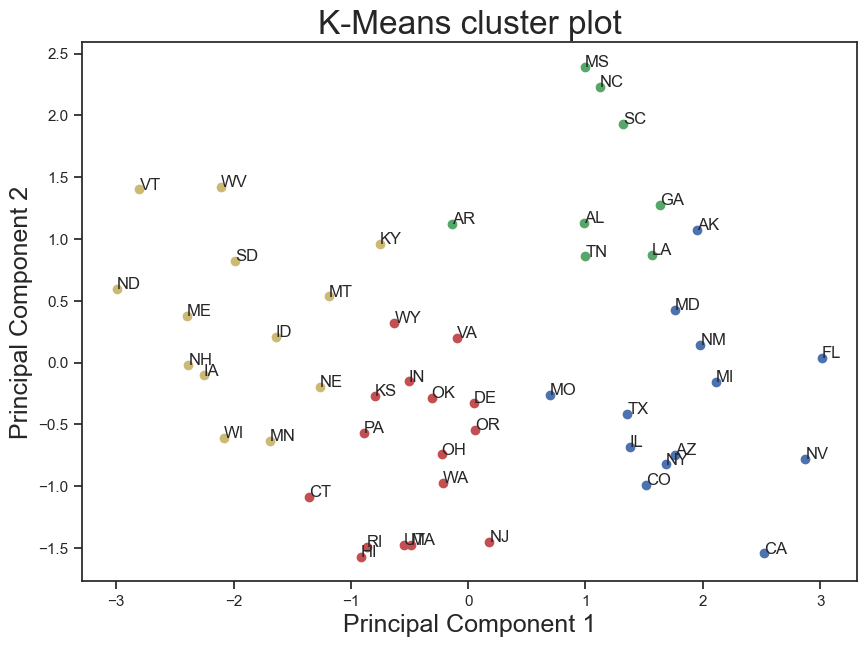

In [298]:
# Plot clusters
fig, ax = plt.subplots(figsize=(10,7))
# Define colours
colours = "rbgy"
# Plot each cluster
for i in range(k):
    ax.scatter(pc_1[cluster_labels == i], pc_2[cluster_labels == i],c = colours[i])

# Add state abbvs to plot
for i in range(0,len(pc_1)):
        txt = arrests_df["State_abv"][i]
        ax.annotate(txt, (pc_1[i], pc_2[i]))

# Add title, and labels, and show
ax.set_title("K-Means cluster plot", size=24)
ax.set_xlabel("Principal Component 1", size=18)
ax.set_ylabel("Principal Component 2", size=18)
plt.show()

### Cluster Analysis

Our 4 clusters are shown in the graph above, and we can see that they are fairly distinct from one another. A combination of the two principal components plotted on the graph above is enough to distinguish between the clusters. 

We can see that there is not a lot of space between individual clusters, but that the cluster boundaries are well defined. We do not have any overlapping clusters, which is a good sign.

We can now add the cluster labels to the "States" in a new dataframe and save that. This could be used alongside a tool like Tableau to create a visualisation of the clusters and how they relate to the geographical location of the states. I have shown an example of this below.

In [299]:
# Create dataframe showing cluster membership and save as csv
df_cluster = pd.DataFrame({"State": arrests_df["State"], "Cluster": cluster_labels})
df_cluster.to_csv("data/state_cluster.csv", index=False)
df_cluster.head()

,State,Cluster
0,Alabama,2
1,Alaska,1
2,Arizona,1
3,Arkansas,2
4,California,1


### State Cluster Visualisation (contiguous US)

We can see that the clusters are fairly distinct from one another, notably the states in the 2nd cluster are all located in the south-east of the US. The majority of the states in the 1st cluster are found in the south-west and the majority of the states in the 3rd cluster are found in the north. The 0th cluster is made up of states that are spread across the US.

![State Clusters](images/state_clusters.png)

### Cluster Insights

By adding the cluster label to our original dataframe, we can then compare the values for each of the features by grouping by the cluster. Doing this we find the following conclusions:

- Cluster 0: These states have a low average murder rate (5.66), a high urban population percentage (73.88%), and average assault and rape rates (138.88, 18.78).
- Cluster 1: These states have a fairly high murder rate (10.82), the highest urban population percentage (76%), and also the highest assault and rape rates (257.38, 33.19).
- Cluster 2: These states have the highest murder rate (13.94), a low urban population percentage (53.75%), and high assault and rape rates (243.63, 21.41).
- Cluster 3: These states have the lowest numbers for all of the features. A murder rate of only 3.6, assault and rape rates of 78.54 and 12.18 respectively and an urban population percentage of 52.08%.

In [300]:
# Add the cluster data to the original dataframe
arrests_df["Cluster"] = cluster_labels
arrests_df.head()

,State,Murder,Assault,UrbanPop,Rape,State_abv,Cluster
0,Alabama,13.20,236,58,21.20,AL,2
1,Alaska,10.00,263,48,44.50,AK,1
2,Arizona,8.10,294,80,31.00,AZ,1
3,Arkansas,8.80,190,50,19.50,AR,2
4,California,9.00,276,91,40.60,CA,1


In [301]:
# Get the mean of each feature for each cluster
arrests_df.groupby("Cluster").mean(numeric_only=True)

,Murder,Assault,UrbanPop,Rape
Cluster,,,,
0,5.66,138.88,73.88,18.78
1,10.82,257.38,76.00,33.19
2,13.94,243.62,53.75,21.41
3,3.60,78.54,52.08,12.18


### Cluster Results

Listed below are the states that make up each of the clusters for your perusal if it interests you to know more.

In [302]:
# List each of the states in each cluster
for i in range(k):
    print(f"Cluster {i}")
    print(arrests_df[arrests_df["Cluster"] == i]["State"].values)
    print()

Cluster 0
['Connecticut' 'Delaware' 'Hawaii' 'Indiana' 'Kansas' 'Massachusetts'
 'New Jersey' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island'
 'Utah' 'Virginia' 'Washington' 'Wyoming']

Cluster 1
['Alaska' 'Arizona' 'California' 'Colorado' 'Florida' 'Illinois'
 'Maryland' 'Michigan' 'Missouri' 'Nevada' 'New Mexico' 'New York' 'Texas']

Cluster 2
['Alabama' 'Arkansas' 'Georgia' 'Louisiana' 'Mississippi' 'North Carolina'
 'South Carolina' 'Tennessee']

Cluster 3
['Idaho' 'Iowa' 'Kentucky' 'Maine' 'Minnesota' 'Montana' 'Nebraska'
 'New Hampshire' 'North Dakota' 'South Dakota' 'Vermont' 'West Virginia'
 'Wisconsin']



### Thank you for taking the time to read through this principal component analysis and clustering exploration. I hope you found it interesting and informative.